In [1]:
import json
import os
import sys

import numpy
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import scipy
import scipy.stats
import seaborn

utils_dir = '../utils'
sys.path.append(utils_dir)
import custom_plots

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [3]:
timepoint_list = [2, 4, 6, 10]

lib_tpm_col = 'TPM_library'
log2_lib_tpm_col = 'log2_TPM_library'

log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]
delta_log2_x_cols = [f'Δlog2_X_{t}hpf' for t in timepoint_list]

res_log2_mrl_cols = [f'res_log2_MRL_{t}hpf' for t in timepoint_list]
res_delta_log2_x_cols = [f'res_Δlog2_X_{t}hpf' for t in timepoint_list]

log2_x_cols = [f'log2_X_{t}hpf' for t in timepoint_list]

In [4]:
# Load data
data_full = pandas.read_csv(
    '../preprocess_data/Zb_5UTR_MPRA_preprocessed.tsv.gz',
    index_col=0,
    sep='\t',
)
# Add length model predictions
data_length_model = pandas.read_csv(
    '../length_model/Zb_5UTR_MPRA_len_preds.tsv.gz',
    index_col=0,
    sep='\t',
)
# Add residuals
data_residuals = pandas.read_csv(
    '../length_model/Zb_5UTR_MPRA_len_residuals.tsv.gz',
    index_col=0,
    sep='\t',
)
# Add CNN predictions
data_cnn_test_preds = pandas.read_csv(
    '../cnn/Zb_5UTR_MPRA_cnn_test_predictions.tsv.gz',
    index_col=0,
    sep='\t',
)
data_cnn_ens_preds = pandas.read_csv(
    '../cnn/Zb_5UTR_MPRA_cnn_ensemble_predictions.tsv.gz',
    index_col=0,
    sep='\t',
)
data_full = pandas.concat([data_full, data_length_model, data_residuals, data_cnn_test_preds, data_cnn_ens_preds], axis=1)

data_full

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_cnn_test_Δlog2_X_6hpf,pred_cnn_test_Δlog2_X_10hpf,pred_cnn_ens_log2_MRL_2hpf,pred_cnn_ens_log2_MRL_4hpf,pred_cnn_ens_log2_MRL_6hpf,pred_cnn_ens_log2_MRL_10hpf,pred_cnn_ens_Δlog2_X_2hpf,pred_cnn_ens_Δlog2_X_4hpf,pred_cnn_ens_Δlog2_X_6hpf,pred_cnn_ens_Δlog2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103.0,2.0,52.427184,23.9,20318.0,20318,...,-0.102279,-0.539334,-1.173310,-0.935138,-0.957661,-1.083553,0.311151,-0.120283,-0.145994,-0.569996
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134.0,0.0,61.940299,35.3,72681.0,72681,...,0.017116,-0.025471,-0.584028,-0.307426,-0.227646,-0.260034,0.233741,-0.137653,0.042448,-0.094097
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178.0,1.0,46.629213,30.1,27446.0,27446,...,0.091336,0.129174,0.563500,0.597735,0.549291,0.619259,0.333496,-0.009866,0.098631,0.103583
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152.0,0.0,46.052632,26.1,113092.0,113092,...,0.118227,0.288848,0.621362,0.405756,0.428594,0.526188,-0.087448,-0.025066,0.144128,0.374926
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153.0,1.0,47.058824,31.8,20320.0,20320,...,0.157745,-0.070825,-0.215164,0.179652,0.105190,0.281734,-0.003381,-0.146717,0.148415,-0.004938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,chr11,+,wdr83os,126.0,126.0,1.0,37.301587,22.8,27060.0,27060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111.0,2.0,34.234234,12.5,86762.0,86762,...,0.011946,-0.211938,-0.053395,-0.119263,-0.027506,-0.115231,-0.261419,0.208852,-0.049214,-0.253377
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197.0,4.0,31.979695,25.9,21263.6,21263,...,0.485773,-0.458338,0.743850,0.894262,0.722649,0.602028,-0.929743,-0.285326,0.407530,-0.232570
ENSDARG00000056892_ENSDART00000148517_5556_mpp6a_23746.2,chr16,-,mpp6a,311.0,161.0,1.0,39.130435,37.6,23746.2,23746,...,0.191941,0.359741,0.935380,0.588156,0.596128,0.686938,-0.403231,0.112754,0.208171,0.413077


In [5]:
# Used later for one-hot encoding
max_seq_len = int(data_full['insert_length'].max())

In [6]:
# Preserve only rows with input tpm above threshold
tpm_threshold = 3
data = data_full[data_full[lib_tpm_col] > tpm_threshold]
print(f"{len(data_full):,} total sequences, {len(data):,} retained.")
data

18,021 total sequences, 17,951 retained.


,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_cnn_test_Δlog2_X_6hpf,pred_cnn_test_Δlog2_X_10hpf,pred_cnn_ens_log2_MRL_2hpf,pred_cnn_ens_log2_MRL_4hpf,pred_cnn_ens_log2_MRL_6hpf,pred_cnn_ens_log2_MRL_10hpf,pred_cnn_ens_Δlog2_X_2hpf,pred_cnn_ens_Δlog2_X_4hpf,pred_cnn_ens_Δlog2_X_6hpf,pred_cnn_ens_Δlog2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103.0,2.0,52.427184,23.9,20318.0,20318,...,-0.102279,-0.539334,-1.173310,-0.935138,-0.957661,-1.083553,0.311151,-0.120283,-0.145994,-0.569996
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134.0,0.0,61.940299,35.3,72681.0,72681,...,0.017116,-0.025471,-0.584028,-0.307426,-0.227646,-0.260034,0.233741,-0.137653,0.042448,-0.094097
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178.0,1.0,46.629213,30.1,27446.0,27446,...,0.091336,0.129174,0.563500,0.597735,0.549291,0.619259,0.333496,-0.009866,0.098631,0.103583
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152.0,0.0,46.052632,26.1,113092.0,113092,...,0.118227,0.288848,0.621362,0.405756,0.428594,0.526188,-0.087448,-0.025066,0.144128,0.374926
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153.0,1.0,47.058824,31.8,20320.0,20320,...,0.157745,-0.070825,-0.215164,0.179652,0.105190,0.281734,-0.003381,-0.146717,0.148415,-0.004938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000060397_ENSDART00000085051_231_hhip_26758.1,chr1,+,hhip,410.0,209.0,2.0,31.578947,26.3,26758.1,26758,...,-0.109184,0.052361,-0.134181,-0.087179,-0.419746,-0.109984,-0.913886,-0.225386,0.150919,-0.314456
ENSDARG00000098284_ENSDART00000170620_10459_ctxn1_29429.4,chr22,+,ctxn1,678.0,174.0,0.0,51.724138,41.2,29429.4,29429,...,0.472315,-0.093756,0.597585,0.891868,0.607369,1.248155,-1.492181,-0.465155,0.577535,-0.145311
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111.0,2.0,34.234234,12.5,86762.0,86762,...,0.011946,-0.211938,-0.053395,-0.119263,-0.027506,-0.115231,-0.261419,0.208852,-0.049214,-0.253377
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197.0,4.0,31.979695,25.9,21263.6,21263,...,0.485773,-0.458338,0.743850,0.894262,0.722649,0.602028,-0.929743,-0.285326,0.407530,-0.232570


In [7]:
# Load chromosomal splits
with open('../cnn/chr_splits.json', 'r') as f:
    chr_splits_info = json.load(f)
# chr_splits_info

In [8]:
# Add full model predictions
for output_idx, output_name in enumerate(log2_mrl_cols + delta_log2_x_cols):
    data['pred_test_' + output_name] = data['pred_len_' + output_name] + data['pred_cnn_test_' + output_name]
    data['pred_full_' + output_name] = data['pred_len_' + output_name] + data['pred_cnn_ens_' + output_name]

C:\Users\casti\AppData\Local\Temp\ipykernel_4292\1544550871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_test_' + output_name] = data['pred_len_' + output_name] + data['pred_cnn_test_' + output_name]
C:\Users\casti\AppData\Local\Temp\ipykernel_4292\1544550871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_full_' + output_name] = data['pred_len_' + output_name] + data['pred_cnn_ens_' + output_name]
C:\Users\casti\AppData\Local\Temp\ipykernel_4292\1544550871.py:3: SettingWith

In [9]:
axis_limits = [
    (-1, 9), # log2_MRL
    (-4, 4), # Δlog2_MRL
    (-5.5, 1.2), # Δlog2_X
    (-10, 1) # log2_X
]

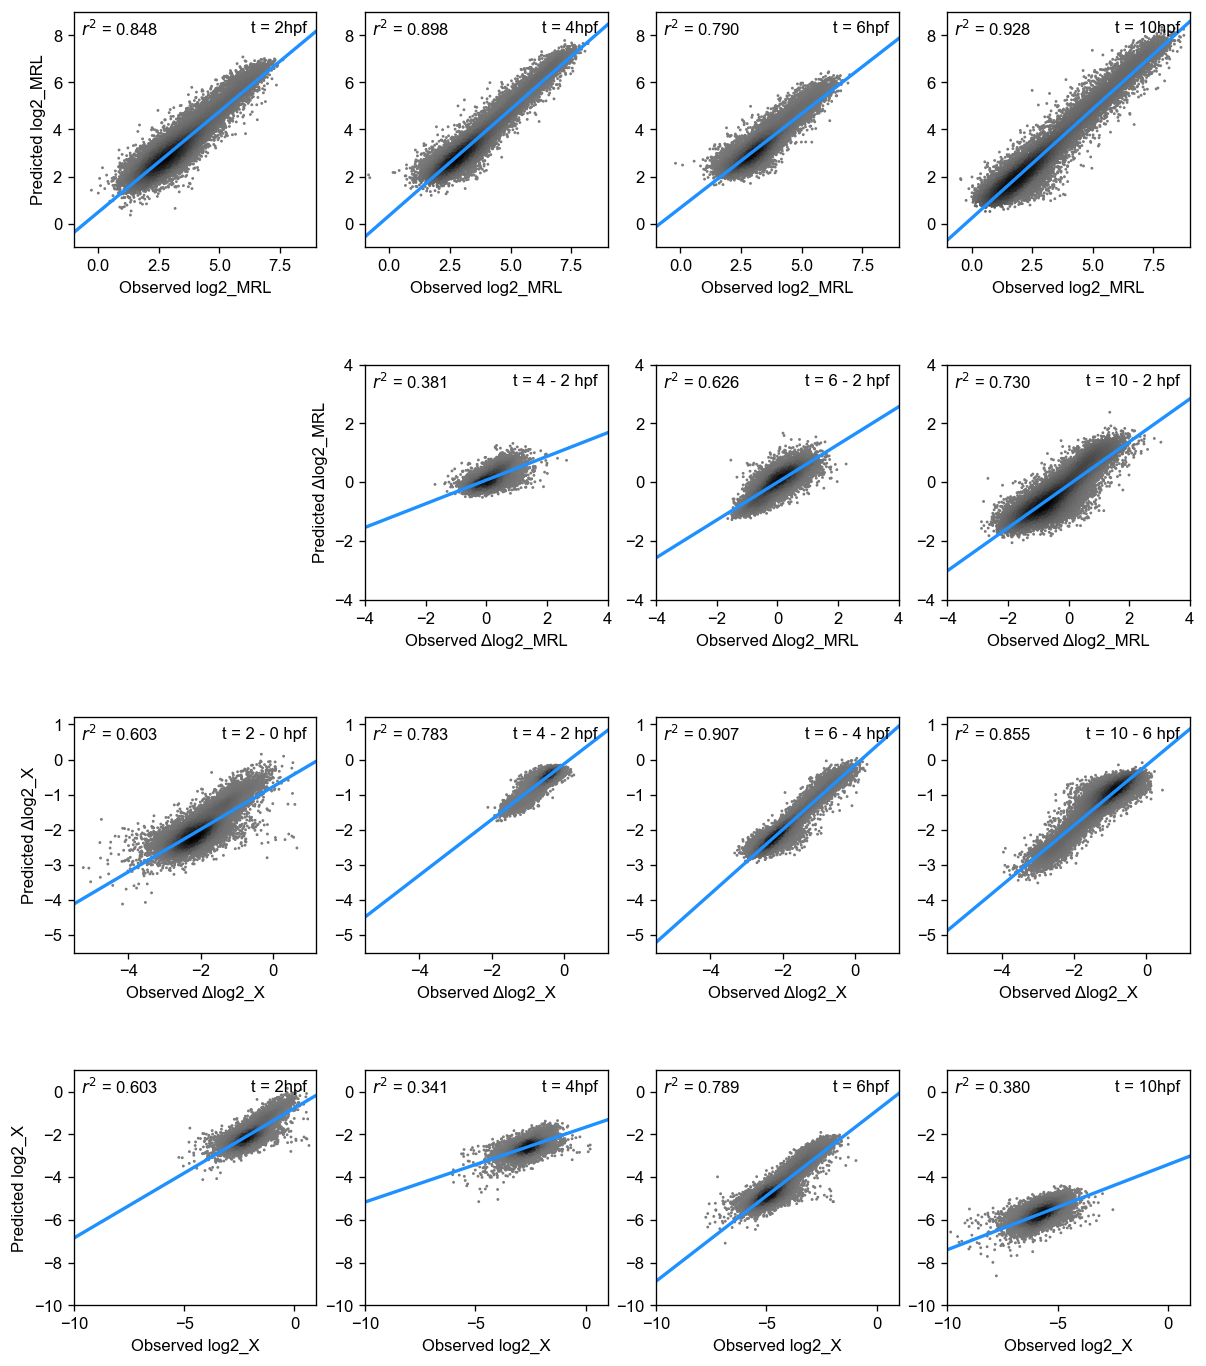

In [10]:
# Plot full model performance
fig = custom_plots.plot_pred_vs_obs(
        data,
        obs_col_prefix='',
        pred_col_prefix='pred_test',
        axis_limits=axis_limits,
)

fig.savefig('full_model_prediction.svg', dpi=200, bbox_inches='tight')
fig.savefig('full_model_prediction.png', dpi=200, bbox_inches='tight')

In [10]:
# Calculate r^2 of length model for performance bar plots
r2_len_dict = {}

# log2MRL
for y_idx, ycol in enumerate(log2_mrl_cols):
    lrres = scipy.stats.linregress(
        data[ycol],
        data['pred_len_' + ycol],
    )
    r2_len_dict[ycol] = lrres.rvalue**2

# Δlog2MRL
for y_idx, ycol in enumerate(log2_mrl_cols[1:]):
    lrres = scipy.stats.linregress(
        data[ycol] - data[log2_mrl_cols[0]],
        data['pred_len_' + ycol] - data['pred_len_' + log2_mrl_cols[0]],
    )
    r2_len_dict[f"Δlog2_MRL_{timepoint_list[y_idx+1]}-2hpf"] = lrres.rvalue**2

# Δlog2X
for y_idx, ycol in enumerate(delta_log2_x_cols):
    lrres = scipy.stats.linregress(
        data[ycol],
        data['pred_len_' + ycol],
    )
    r2_len_dict[f"Δlog2_X_{timepoint_list[y_idx]}hpf"] = lrres.rvalue**2

# log2X
for y_idx, ycol in enumerate(delta_log2_x_cols):
    lrres = scipy.stats.linregress(
        data[[c for c in delta_log2_x_cols[:y_idx+1]]].sum(axis=1),
        data[['pred_len_' + c for c in delta_log2_x_cols[:y_idx+1]]].sum(axis=1),
    )
    r2_len_dict[f"log2_X_{timepoint_list[y_idx]}hpf"] = lrres.rvalue**2

r2_len_df = pandas.DataFrame({k: [v] for k, v in r2_len_dict.items()})
r2_len_df

,log2_MRL_2hpf,log2_MRL_4hpf,log2_MRL_6hpf,log2_MRL_10hpf,Δlog2_MRL_4-2hpf,Δlog2_MRL_6-2hpf,Δlog2_MRL_10-2hpf,Δlog2_X_2hpf,Δlog2_X_4hpf,Δlog2_X_6hpf,Δlog2_X_10hpf,log2_X_2hpf,log2_X_4hpf,log2_X_6hpf,log2_X_10hpf
0,0.700104,0.823744,0.637561,0.849244,0.162517,0.400373,0.51167,0.378535,0.672427,0.862202,0.768545,0.378535,0.05508,0.687638,0.019107


In [11]:
# Calculate r^2 of full model for performance bar plots
r2_list = []
for split_idx, chr_split_info in enumerate(chr_splits_info):

    # Select data from test chromosomes
    test_chrs = chr_split_info['test']
    data_test = data[data['chr'].isin(test_chrs)]

    r2_test_dict = {}
    # log2MRL
    for y_idx, ycol in enumerate(log2_mrl_cols):
        lrres = scipy.stats.linregress(
            data_test[ycol],
            data_test['pred_test_' + ycol],
        )
        r2_test_dict[ycol] = lrres.rvalue**2

    # Δlog2MRL
    for y_idx, ycol in enumerate(log2_mrl_cols[1:]):
        lrres = scipy.stats.linregress(
            data_test[ycol] - data_test[log2_mrl_cols[0]],
            data_test['pred_test_' + ycol] - data_test['pred_test_' + log2_mrl_cols[0]],
        )
        r2_test_dict[f"Δlog2_MRL_{timepoint_list[y_idx+1]}-2hpf"] = lrres.rvalue**2

    # Δlog2X
    for y_idx, ycol in enumerate(delta_log2_x_cols):
        lrres = scipy.stats.linregress(
            data_test[ycol],
            data_test['pred_test_' + ycol],
        )
        r2_test_dict[f"Δlog2_X_{timepoint_list[y_idx]}hpf"] = lrres.rvalue**2

    # log2X
    for y_idx, ycol in enumerate(delta_log2_x_cols):
        lrres = scipy.stats.linregress(
            data_test[[c for c in delta_log2_x_cols[:y_idx+1]]].sum(axis=1),
            data_test[['pred_test_' + c for c in delta_log2_x_cols[:y_idx+1]]].sum(axis=1),
        )
        r2_test_dict[f"log2_X_{timepoint_list[y_idx]}hpf"] = lrres.rvalue**2

    r2_list.append(r2_test_dict)

r2_full_df = pandas.DataFrame(r2_list)
r2_full_df

,log2_MRL_2hpf,log2_MRL_4hpf,log2_MRL_6hpf,log2_MRL_10hpf,Δlog2_MRL_4-2hpf,Δlog2_MRL_6-2hpf,Δlog2_MRL_10-2hpf,Δlog2_X_2hpf,Δlog2_X_4hpf,Δlog2_X_6hpf,Δlog2_X_10hpf,log2_X_2hpf,log2_X_4hpf,log2_X_6hpf,log2_X_10hpf
0,0.875763,0.918642,0.821273,0.942880,0.390144,0.672521,0.767182,0.638404,0.817887,0.928269,0.872333,0.638404,0.370396,0.811593,0.370282
1,0.846823,0.899891,0.799198,0.926331,0.406789,0.623826,0.745513,0.655875,0.793928,0.901320,0.857375,0.655875,0.388405,0.804374,0.415685
2,0.863060,0.914812,0.821532,0.936780,0.383821,0.631164,0.727802,0.645349,0.806185,0.911199,0.862335,0.645349,0.396953,0.815740,0.427382
3,0.824676,0.890006,0.771214,0.924913,0.358478,0.587840,0.718039,0.589376,0.776701,0.903728,0.849502,0.589376,0.357163,0.787823,0.420471
4,0.848243,0.896761,0.778508,0.925281,0.391640,0.648731,0.724812,0.605918,0.759091,0.901121,0.854750,0.605918,0.334259,0.781764,0.355843
5,0.852387,0.895811,0.790281,0.929795,0.399062,0.628201,0.753994,0.596292,0.779088,0.911089,0.856696,0.596292,0.314585,0.799367,0.365214
6,0.846360,0.899278,0.794582,0.923682,0.391294,0.631876,0.724620,0.579018,0.790222,0.907378,0.856693,0.579018,0.323262,0.784721,0.383666
7,0.840777,0.891630,0.780593,0.924870,0.363361,0.623177,0.718211,0.608337,0.776335,0.904249,0.856878,0.608337,0.338206,0.788974,0.383179
8,0.839145,0.887430,0.774898,0.918183,0.386828,0.624979,0.715043,0.590053,0.792017,0.905912,0.853394,0.590053,0.330433,0.776087,0.395097
9,0.844089,0.888149,0.775431,0.923453,0.357595,0.603619,0.714719,0.559939,0.760719,0.897291,0.837870,0.559939,0.314661,0.761840,0.334870


In [12]:
r2_full_df.mean(axis=0)

log2_MRL_2hpf        0.848132
log2_MRL_4hpf        0.898241
log2_MRL_6hpf        0.790751
log2_MRL_10hpf       0.927617
Δlog2_MRL_4-2hpf     0.382901
Δlog2_MRL_6-2hpf     0.627594
Δlog2_MRL_10-2hpf    0.730994
Δlog2_X_2hpf         0.606856
Δlog2_X_4hpf         0.785217
Δlog2_X_6hpf         0.907156
Δlog2_X_10hpf        0.855783
log2_X_2hpf          0.606856
log2_X_4hpf          0.346832
log2_X_6hpf          0.791228
log2_X_10hpf         0.385169
dtype: float64

C:\Users\casti\AppData\Local\Temp\ipykernel_4292\1918924450.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([s.replace('diff_', 'Δ') for s in cols_to_plot], rotation=90)


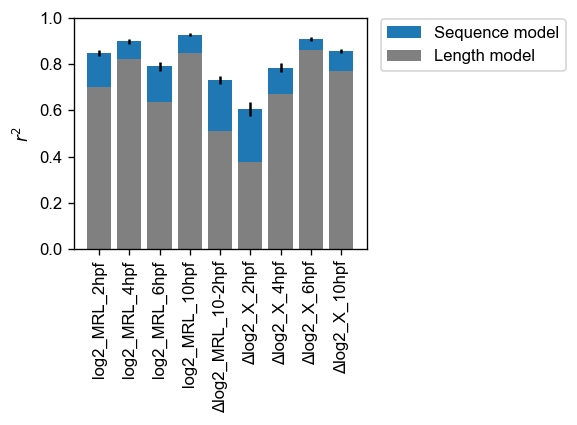

In [15]:
# Plot r^2 summary
# cols_to_plot = r2_full_df.columns.to_list()
cols_to_plot = log2_mrl_cols + ['Δlog2_MRL_10-2hpf'] + delta_log2_x_cols

fig, ax = pyplot.subplots(figsize=(0.35*len(cols_to_plot), 2.5))
ax.bar(cols_to_plot, r2_full_df[cols_to_plot].mean(axis=0), yerr=r2_full_df[cols_to_plot].std(axis=0), label='Sequence model')
ax.bar(cols_to_plot, [r2_len_dict[k] for k in cols_to_plot], color='grey', label='Length model')
ax.set_xticklabels([s.replace('diff_', 'Δ') for s in cols_to_plot], rotation=90)
ax.set_ylabel('$r^2$')
ax.set_ylim(0, 1)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.03))
fig.savefig('len_vs_seq_model.svg', dpi=200, bbox_inches='tight')

In [28]:
# Save dataframe with predictions
data.to_csv('Zb_5UTR_MPRA_with_preds.tsv.gz', sep='\t')